In [391]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [392]:
# Folder
mission_path = os.path.join(Path().home(), "digiforest_mission_data/latest")

In [393]:
# Other params
base_inverted = True

## Matplotlib config

In [394]:
cm = 1 / 2.54
plot_width = 8.89 * cm
plot_height = 4 * cm

plt.rcParams["font.size"] = 8

## Load data

### Load pose files

In [405]:
from scipy.spatial.transform import Rotation as R


def read_poses_file(filename, base_inverted=False):
    df = pd.read_csv(filename)

    # Generate timestamp from sec and nsec
    ts = 1e9 * df["sec"] + df["nsec"]  # In nanoseconds
    df.index = pd.to_datetime(ts)

    # Parse data
    poses = {}
    for ts, x, y, z, qx, qy, qz, qw in zip(
        df.index, df["x"], df["y"], df["z"], df["qx"], df["qy"], df["qz"], df["qw"]
    ):
        poses[f"{ts:.10f}"] = np.eye(4)
        poses[f"{ts:.10f}"][0:3, 3] = np.array([x, y, z])
        poses[f"{ts:.10f}"][0:3, 0:3] = R.from_quat([qx, qy, qz, qw]).as_matrix()

        # TODO: fix base inversion

    return df, poses


df_state_poses, poses_list = read_poses_file(
    os.path.join(mission_path, "states/state_pose_data.csv"), base_inverted=base_inverted
)

### Load twist files

In [396]:
def read_twist_file(filename, base_inverted=False):
    df = pd.read_csv(filename)

    # Generate timestamp from sec and nsec
    ts = 1e9 * df["sec"] + df["nsec"]  # In nanoseconds
    df.index = pd.to_datetime(ts)

    # Correct twist due to base inversion
    if base_inverted:
        df["vx"] *= -1
        df["vy"] *= -1

    # Speeds
    df["lin_speed"] = (df["vx"] ** 2 + df["vy"] ** 2).pow(1.0 / 2)
    df["ang_speed"] = df["wz"].abs()

    return df


df_state_twist = read_twist_file(
    os.path.join(mission_path, "states/state_twist_data.csv"), base_inverted=base_inverted
)
df_reference_twist = read_twist_file(
    os.path.join(mission_path, "states/reference_twist_data.csv"), base_inverted=base_inverted
)
df_operator_twist = read_twist_file(
    os.path.join(mission_path, "states/operator_twist_data.csv"), base_inverted=base_inverted
)

In [397]:
# Extend indices
joined_indices = df_state_twist.index.union(df_reference_twist.index).drop_duplicates()
joined_indices = joined_indices.union(df_operator_twist.index).drop_duplicates()

df_state_twist = df_state_twist.reindex(index=joined_indices)
df_state_twist = df_state_twist.interpolate(method="index")

df_reference_twist = df_reference_twist.reindex(index=joined_indices)
df_reference_twist = df_reference_twist.interpolate(method="index")

### Read other operator signals

### Determine operator interventions
This is required for autonomy metrics

In [398]:
# Interventions from safety officer
df_state_twist["safety_intervention"] = df_operator_twist["lin_speed"] > 0.01
df_state_twist["safety_intervention"] = df_state_twist[
    "safety_intervention"
].interpolate(method="pad")

# Interventions from forestry operator


# Total interventions
df_state_twist["interventions"] = df_state_twist["safety_intervention"]

### Load SLAM graph
Required for distance computation and coverage

In [399]:
df_slam, slam_graph = read_poses_file(
    os.path.join(mission_path, "states/slam_graph_data.csv")
)

#### Estimate area

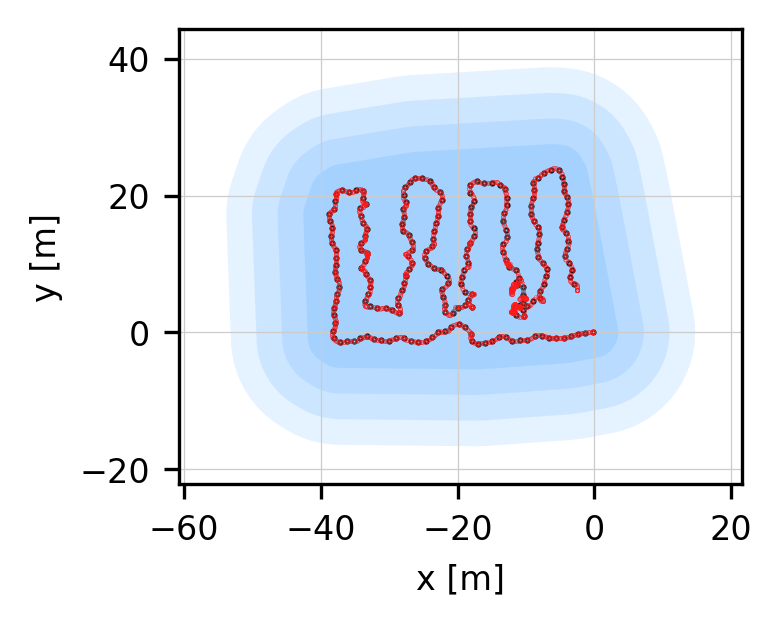

In [416]:
odom_points = df_state_poses[["x", "y"]].to_numpy()
slam_points = df_slam[["x", "y"]].to_numpy()

import shapely
import shapely.plotting

sp_odom_points = shapely.MultiPoint(odom_points)

sp_slam_points = shapely.MultiPoint(slam_points)
sp_slam_hull = sp_slam_points.convex_hull

sensor_range = 30 / 2

sensing_hull = sp_slam_hull.buffer(sensor_range)

# Plotting
plot_width = 15 * cm
plot_height = 5 * cm
fig, ax = plt.subplots(
    1, 1, figsize=(plot_width, plot_height), constrained_layout=False, dpi=300
)
plt.grid(axis="both", color="0.8", linewidth=0.3)

# Plot points
shapely.plotting.plot_points(sp_slam_points, markersize=0.5, marker="o", color=(0.1, 0.1, 0.1), fillstyle="full")
shapely.plotting.plot_points(sp_odom_points, markersize=0.1, marker="o", color=(1.0, 0.1, 0.1), fillstyle="full")

# Plot sensor polygon
shapely.plotting.plot_polygon(
    sp_slam_hull.buffer(sensor_range * 0.25),
    add_points=False,
    color=(0, 0.5, 1),
    linewidth=0,
    alpha=0.1,
)
shapely.plotting.plot_polygon(
    sp_slam_hull.buffer(sensor_range * 0.50),
    add_points=False,
    color=(0, 0.5, 1),
    linewidth=0,
    alpha=0.1,
)
shapely.plotting.plot_polygon(
    sp_slam_hull.buffer(sensor_range * 0.75),
    add_points=False,
    color=(0, 0.5, 1),
    linewidth=0,
    alpha=0.1,
)
shapely.plotting.plot_polygon(
    sp_slam_hull.buffer(sensor_range * 1.00),
    add_points=False,
    color=(0, 0.5, 1),
    linewidth=0,
    alpha=0.1,
)
# shapely.plotting.plot_polygon(hull, add_points=False)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.margins(x=0.1, y=0.1)

#### 

### Normalize time

In [ ]:
ref_ts = df_state_twist.index[0]
df_state_twist.index = df_state_twist.index - ref_ts
df_reference_twist.index = df_reference_twist.index - ref_ts
df_operator_twist.index = df_operator_twist.index - ref_ts
df_slam.index = df_slam.index - ref_ts

## Mission statistics

In [ ]:
import scipy.integrate as integrate

stats = {}

# Constants
stats["sqm_to_ha"] = 0.0001
stats["sec_to_min"] = 1 / 60
stats["sec_to_hour"] = 1 / 3600

# Speed
stats["max_lin_speed"] = df_state_twist["lin_speed"].max()
stats["min_lin_speed"] = df_state_twist["lin_speed"].min()
stats["mean_lin_speed"] = df_state_twist["lin_speed"].mean()
stats["std_lin_speed"] = df_state_twist["lin_speed"].std()

stats["mean_ang_speed"] = df_state_twist["ang_speed"].mean()
stats["std_ang_speed"] = df_state_twist["ang_speed"].std()

# Distance walked
stats["distance_m"] = (
    df_slam[["x", "y", "z"]]
    .diff()
    .apply(lambda values: sum([v**2 for v in values]), axis=1)
    .sum()
)

# Mission time
stats["time_sec"] = (df_slam.index[-1] - df_slam.index[0]).total_seconds()

# Interventions
stats["interventions"] = integrate.simpson(
    df_state_twist["interventions"], df_state_twist.index.total_seconds()
)

# Percentaje of interventions
stats["interventions_perc"] = stats["interventions"] / stats["time_sec"] * 100

# Area covered
stats["area_m2"] = hull.area * stats["sqm_to_ha"]
stats["sensor_range_m"] = sensor_range
stats["sensed_area_m2"] = sensing_hull.area * stats["sqm_to_ha"]

# Hectares per second
stats["ha_per_sec"] = stats["area_m2"] / stats["time_sec"]
stats["ha_per_min"] = stats["area_m2"] / (stats["time_sec"] * stats["sec_to_min"])
stats["ha_per_hour"] = stats["area_m2"] / (stats["time_sec"] * stats["sec_to_hour"])

# Print
for k, v in stats.items():
    print(f"{k:>20}: {v:<20.4f}")

           sqm_to_ha: 0.0001              
          sec_to_min: 0.0167              
         sec_to_hour: 0.0003              
       max_lin_speed: 1.0147              
       min_lin_speed: 0.0014              
      mean_lin_speed: 0.4829              
       std_lin_speed: 0.2120              
      mean_ang_speed: 0.3823              
       std_ang_speed: 0.2382              
          distance_m: 263.0584            
            time_sec: 563.0962            
       interventions: 29.4026             
  interventions_perc: 5.2216              
             area_m2: 0.0866              
      sensor_range_m: 15.0000             
      sensed_area_m2: 0.3322              
          ha_per_sec: 0.0002              
          ha_per_min: 0.0092              
         ha_per_hour: 0.5533              


## Plots

### Robot velocity

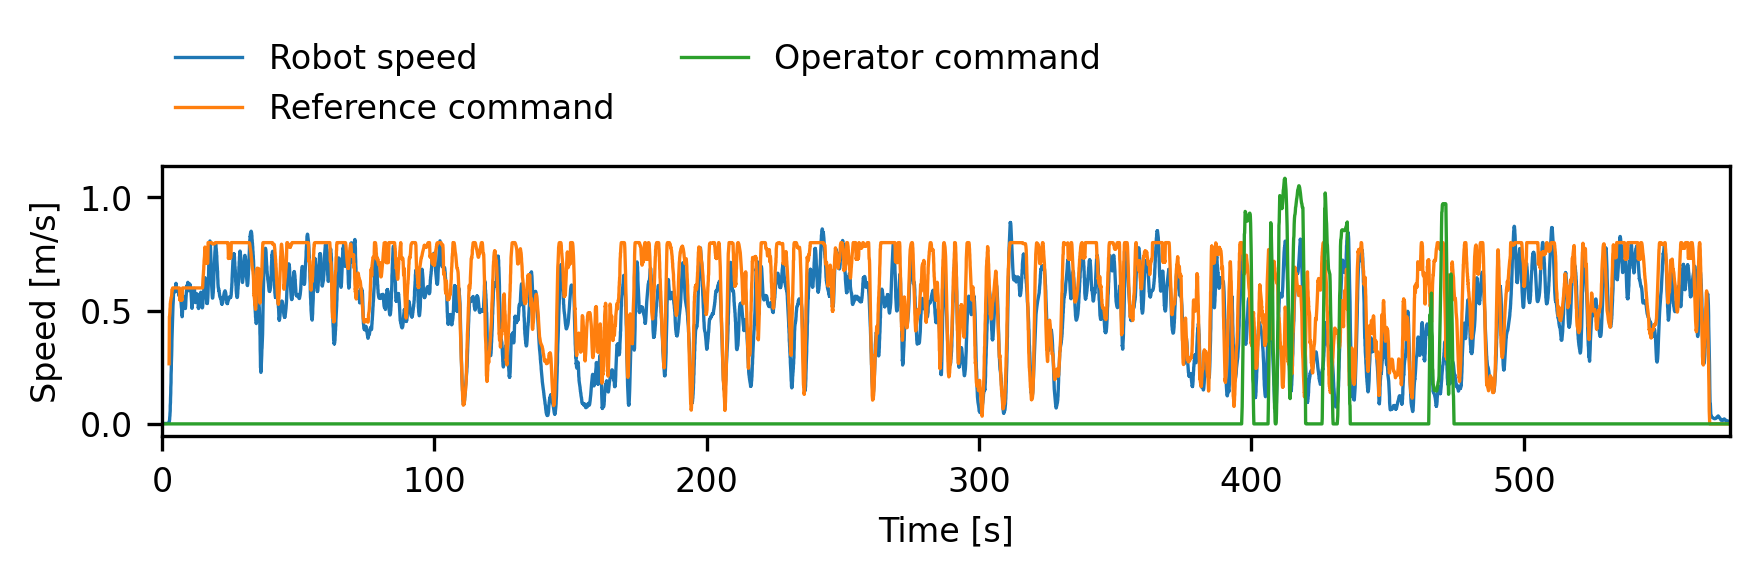

In [ ]:
smoothing_window="1000ms"
linewidth = 0.8

fig, ax = plt.subplots(
    1, 1, figsize=(plot_width, plot_height), constrained_layout=False, dpi=300
)

plt.plot(
    df_state_twist.index.total_seconds(),
    df_state_twist["lin_speed"].rolling(smoothing_window).mean(),
    label="Robot speed",
    linewidth=linewidth,
)
plt.plot(
    df_reference_twist.index.total_seconds(),
    df_reference_twist["lin_speed"].rolling(smoothing_window).mean(),
    label="Reference command",
    linewidth=linewidth,
)
plt.plot(
    df_operator_twist.index.total_seconds(),
    df_operator_twist["lin_speed"].rolling(smoothing_window).mean(),
    label="Operator command",
    linewidth=linewidth,
)

ax.legend(edgecolor=(1, 1, 1, 0), framealpha=0.9, loc=(0, 1.1), ncol=2)
# ax.set_title('Computation Time')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Speed [m/s]")
ax.margins(x=0)

# Export
fig.set_tight_layout(True)
fig.savefig(os.path.join(mission_path, "mission_velocity.pdf"))

### Autonomy plot